# Essay Grading System using LangGraph

## Overview
This notebook presents an automated essay grading system implemented using LangGraph and an LLM model. The system evaluates essays based on four key criteria: relevance, grammar, structure, and depth of analysis.

## Motivation
Automated essay grading systems can significantly streamline the assessment process in educational settings, providing consistent and objective evaluations. This implementation aims to demonstrate how large language models and graph-based workflows can be combined to create a sophisticated grading system.

## Key Components
1. State Graph: Defines the workflow of the grading process
2. LLM Model: Provides the underlying language understanding and analysis
3. Grading Functions: Separate functions for each evaluation criterion
4. Conditional Logic: Determines the flow of the grading process based on interim scores

## Method
The system follows a step-by-step approach to grade essays:

1. Content Relevance: Assesses how well the essay addresses the given topic
2. Grammar Check: Evaluates the essay's language usage and grammatical correctness
3. Structure Analysis: Examines the organization and flow of ideas in the essay
4. Depth of Analysis: Gauges the level of critical thinking and insight presented

## Other Method

1. Task completion (Mức độ hoàn thành đề bài)
2. Corehence (Mạch lạc)
3. Vocabulary (Từ vựng)
4. Grammar (Ngữ pháp)

Task Fullfilment: Mạch lạc & Mức độ hoàn thành đề bài

Each step is conditionally executed based on the scores from previous steps, allowing for early termination of low-quality essays. The final score is a weighted average of all individual component scores.

## Conclusion
This notebook demonstrates a flexible and extensible approach to automated essay grading. By leveraging the power of large language models and a graph-based workflow, it offers a nuanced evaluation of essays that considers multiple aspects of writing quality. This system could be further refined and adapted for various educational contexts, potentially improving the efficiency and consistency of essay assessments.



## System Workflow

<div style="text-align: center;">

<img src="../images/essay_grading_system_langgraph.svg" alt="essay grading system langgraph" style="width:80%; height:auto;">
</div>

## Setup and Imports

This cell imports necessary libraries and sets up the OpenAI API key.

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
# from langchain_ollama.llms import OllamaLLM
from langchain_core.prompts import ChatPromptTemplate
import os
from dotenv import load_dotenv
import re

# Load environment variables and set OpenAI API key
load_dotenv()

True

## State Definition

This cell defines the State class, which represents the state of our grading process.

In [3]:
import operator
from typing import Annotated

def strstr(a: str, b: str) -> list:
    return a

def floatfloat(a: str, b: float) -> list:
    return a

class State(TypedDict):
    """Represents the state of the essay grading process."""
    essay: str
    band: float
    topic: str
    
    relevance_score: float
    task_completion: str
    
    grammar_score: float
    grammar: str
    
    vocabulary_score: float
    vocabulary: str
    
    structure_score: float
    depth_score: float
    coherence: str
    
    final_score: float
    rewritten_essay: str

## Language Model Initialization

This cell initializes the ChatOpenAI model.

In [4]:
# Initialize the ChatOpenAI model
llm = ChatOpenAI(model="gpt-4o-mini")
# llm = OllamaLLM(model="llama3.2:1b")

## Grading Functions

This cell defines the functions used in the grading process, including score extraction and individual grading components.

In [5]:
def extract_score(content: str) -> float:
    """Extract the numeric score from the LLM's response."""
    match = re.search(r'Score:\s*(\d+(\.\d+)?)', content)
    if match:
        return float(match.group(1))
    raise ValueError(f"Could not extract score from: {content}")

# start with 'Task completion: ' followed by 'Yes' or 'No', "
#         "then
def check_task_completion(state: State) -> State:
    """Check the completion of the task return explanation."""
    prompt = ChatPromptTemplate.from_template(
        "You are a teacher grading an essay on the topic of '{topic}'. "
        "The band of the student is {band}. "
        " Analyze the following essay and determine if the task has been completed. "
        "Your response should provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"], topic=state["topic"], band=state["band"]))
    try:
        state["task_completion"] = result.content
    except ValueError as e:
        print(f"Error in check_relevance: {e}")
        state["task_completion"] = "Task completion: No"
    return state

def check_relevance(state: State) -> State:
    """Check the relevance of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "You are a teacher grading an essay on the topic of '{topic}'. "
        "The band of the student is {band}. "
        "Analyze the relevance of the following essay to the given topic. "
        "Provide a relevance score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"], topic=state["topic"], band=state["band"]))
    try:
        print(result)
        state["relevance_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in check_relevance: {e}")
        state["relevance_score"] = 0.0
    return state

def check_grammar(state: State) -> State:
    """Check the grammar of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "You are a teacher grading an essay on the topic of '{topic}'. "
        "The band of the student is {band}. "
        "Analyze the grammar and language usage in the following essay. "
        "Provide a grammar score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"], topic=state["topic"], band=state["band"]))
    try:
        state["grammar_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in check_grammar: {e}")
        state["grammar_score"] = 0.0
    return state

def grammar_correction(state: State) -> State:
    """Correct the grammar of the essay. return incorrect grammar and corrected grammar."""
    prompt = ChatPromptTemplate.from_template(
        "You are a teacher grading an essay on the topic of '{topic}'. "
        "The band of the student is {band}. "
        "Correct the grammar and language usage in the following essay."
        "Your response should start with 'Incorrect grammar: ' followed by the incorrect grammar, "
        "then provide the corrected grammar.\n\nEssay: {essay}"
    )
    try:
        result = llm.invoke(prompt.format(essay=state["essay"], topic=state["topic"], band=state["band"]))
        state["grammar"] = result.content
    except ValueError as e:
        print(f"Error in grammar_correction: {e}")
        state["grammar"] = "Incorrect grammar: No errors found."
    return state

def check_vocabulary(state: State) -> State:
    """Check the vocabulary of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "You are a teacher grading an essay on the topic of '{topic}'. "
        "The band of the student is {band}. "
        "Analyze the vocabulary and language usage in the following essay. "
        "Provide a vocabulary score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"], topic=state["topic"], band=state["band"]))
    try:
        state["vocabulary_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in check_vocabulary: {e}")
        state["vocabulary_score"] = 0.0
    return state

def vocabulary_enhancement(state: State) -> State:
    """Enhance the vocabulary of the essay. return original essay and rewritten essay."""
    prompt = ChatPromptTemplate.from_template(
        "You are a teacher grading an essay on the topic of '{topic}'. "
        "The band of the student is {band}. "
        "Enhance the vocabulary and language usage in the following essay."
        "Your response should start with 'Original essay: ' followed by the original essay, "
        "then provide the rewritten essay.\n\nEssay: {essay}"
    )
    try:
        result = llm.invoke(prompt.format(essay=state["essay"], topic=state["topic"], band=state["band"]))
        state["vocabulary"] = result.content
    except ValueError as e:
        print(f"Error in vocabulary_enhancement: {e}")
        state["vocabulary"] = "Original essay: No enhancements made."
    return state

def analyze_structure(state: State) -> State:
    """Analyze the structure of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "You are a teacher grading an essay on the topic of '{topic}'. "
        "The band of the student is {band}. "
        "Analyze the structure of the following essay. "
        "Provide a structure score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"], topic=state["topic"], band=state["band"]))
    try:
        state["structure_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in analyze_structure: {e}")
        state["structure_score"] = 0.0
    return state

def evaluate_depth(state: State) -> State:
    """Evaluate the depth of analysis in the essay."""
    prompt = ChatPromptTemplate.from_template(
        "You are a teacher grading an essay on the topic of '{topic}'. "
        "The band of the student is {band}. "
        "Evaluate the depth of analysis in the following essay. "
        "Provide a depth score between 0 and 1. "
        "Your response should start with 'Score: ' followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"], topic=state["topic"], band=state["band"]))
    try:
        state["depth_score"] = extract_score(result.content)
    except ValueError as e:
        print(f"Error in evaluate_depth: {e}")
        state["depth_score"] = 0.0
    return state

def check_coherence(state: State) -> State:
    """Check the coherence of the essay."""
    prompt = ChatPromptTemplate.from_template(
        "You are a teacher grading an essay on the topic of '{topic}'. "
        "The band of the student is {band}. "
        "Analyze the coherence and logical flow of the following essay. "
        "Provide an explanation of the coherence of the essay.\n\nEssay: {essay}"
    )
    result = llm.invoke(prompt.format(essay=state["essay"], topic=state["topic"], band=state["band"]))
    state["coherence"] = result.content
    return state

def rewrite_essay(state: State) -> State:
    """Rewrite the essay based on the feedback provided."""
    prompt = ChatPromptTemplate.from_template(
        "You are a teacher grading an essay on the topic of '{topic}'. "
        "The band of the student is {band}. "
        "Rewrite the following essay based on the feedback provided.\n\n"
        "Task completion: {task_completion}\n"
        "Relevance score: {relevance_score}\n"
        "Grammar score: {grammar_score}\n"
        "Vocabulary score: {vocabulary_score}\n"
        "Structure score: {structure_score}\n"
        "Depth score: {depth_score}\n"
        "Coherence: {coherence}\n\n"
        "Essay: {essay}"
    )
    result = llm.invoke(prompt.format(**state))
    state["rewritten_essay"] = result.content
    return state

def calculate_final_score(state: State) -> State:
    """Calculate the final score based on individual component scores."""
    state["final_score"] = (
        state["relevance_score"] * 0.3 +
        state["grammar_score"] * 0.2 +
        state["structure_score"] * 0.2 +
        state["depth_score"] * 0.3
    )
    return state

## Workflow Definition

This cell defines the grading workflow using StateGraph.

In [17]:
# Initialize the StateGraph
workflow = StateGraph(State)

# Add nodes to the graph
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("check_task_completion", check_task_completion)
workflow.add_node("check_grammar", check_grammar)
workflow.add_node("grammar_correction", grammar_correction)
workflow.add_node("check_vocabulary", check_vocabulary)
workflow.add_node("vocabulary_enhancement", vocabulary_enhancement)
workflow.add_node("analyze_structure", analyze_structure)
workflow.add_node("evaluate_depth", evaluate_depth)
workflow.add_node("check_coherence", check_coherence)
workflow.add_node("rewrite_essay", rewrite_essay)
workflow.add_node("calculate_final_score", calculate_final_score)

# Define and add conditional edges
workflow.add_conditional_edges(
    "check_relevance",
    lambda x: "check_grammar" if x["relevance_score"] > 0.5 else "calculate_final_score",
    # ["check_grammar", "grammar_correction", "check_vocabulary", "vocabulary_enhancement"]
)

# workflow.add_edge("check_grammar", "grammar_correction")

# workflow.add_conditional_edges(
#     "analyze_structure",
#     lambda x: "evaluate_depth" if x["structure_score"] > 0.7 else "calculate_final_score"
# )

list = ["check_task_completion", "check_grammar", "grammar_correction", "check_vocabulary", "vocabulary_enhancement", "analyze_structure", "evaluate_depth", "check_coherence", "rewrite_essay"]
for i in range(len(list)-1):
    workflow.add_edge(
        list[i],
        list[i+1]
    )

workflow.add_edge(list[-1], "calculate_final_score")

# Set the entry point
workflow.set_entry_point("check_relevance")

# Set the exit point
workflow.add_edge("calculate_final_score", END)

# Compile the graph
app = workflow.compile()

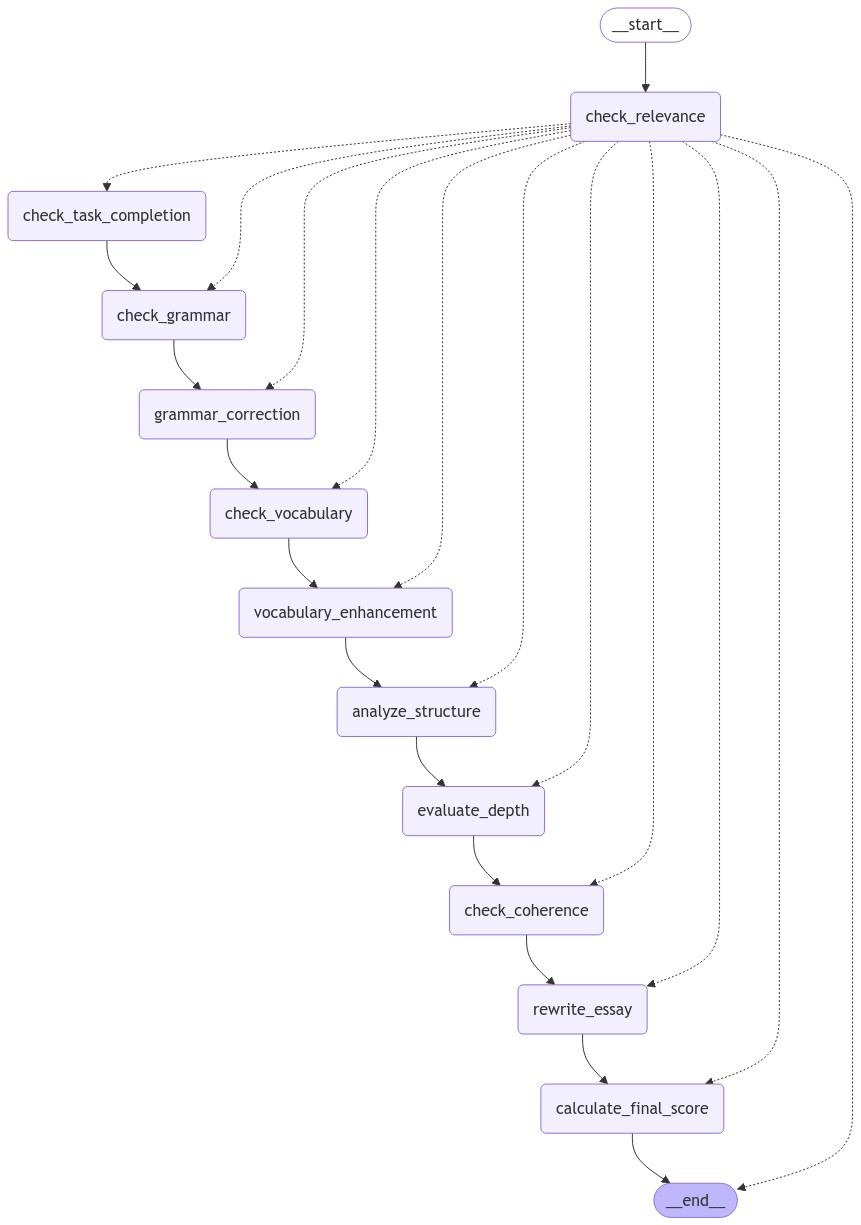

In [18]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## Essay Grading Function

This cell defines the main function to grade an essay using the defined workflow.

In [22]:
def grade_essay(essay: str, band: float, topic: str) -> dict:
    """Grade the given essay using the defined workflow."""
    initial_state = State(
        essay=essay,
        band=band,
        topic=topic,
        relevance_score=0.0,
        task_completion="Task completion: No",
        grammar_score=0.0,
        grammar="Incorrect grammar: No errors found.",
        vocabulary_score=0.0,
        vocabulary="Original essay: No enhancements made.",
        structure_score=0.0,
        depth_score=0.0,
        coherence="",
        rewritten_essay="",
        final_score=0.0
    )
    result = app.invoke(initial_state)
    return result

## Sample Essay

This cell contains a sample essay for testing the grading system.

In [23]:
sample_essay = """
    The Impact of Artificial Intelligence on Modern Society

    Artificial Intelligence (AI) has become an integral part of our daily lives, 
    revolutionizing various sectors including healthcare, finance, and transportation. 
    This essay explores the profound effects of AI on modern society, discussing both 
    its benefits and potential challenges.

    One of the most significant impacts of AI is in the healthcare industry. 
    AI-powered diagnostic tools can analyze medical images with high accuracy, 
    often surpassing human capabilities. This leads to earlier detection of diseases 
    and more effective treatment plans. Moreover, AI algorithms can process vast 
    amounts of medical data to identify patterns and insights that might escape 
    human observation, potentially leading to breakthroughs in drug discovery and 
    personalized medicine.

    In the financial sector, AI has transformed the way transactions are processed 
    and monitored. Machine learning algorithms can detect fraudulent activities in 
    real-time, enhancing security for consumers and institutions alike. Robo-advisors 
    use AI to provide personalized investment advice, democratizing access to 
    financial planning services.

    The transportation industry is another area where AI is making significant strides. 
    Self-driving cars, powered by complex AI systems, promise to reduce accidents 
    caused by human error and provide mobility solutions for those unable to drive. 
    In logistics, AI optimizes routing and inventory management, leading to more 
    efficient supply chains and reduced environmental impact.

    However, the rapid advancement of AI also presents challenges. There are concerns 
    about job displacement as AI systems become capable of performing tasks 
    traditionally done by humans. This raises questions about the need for retraining 
    and reskilling the workforce to adapt to an AI-driven economy.

    Privacy and ethical concerns also arise with the increasing use of AI. The vast 
    amount of data required to train AI systems raises questions about data privacy 
    and consent. Additionally, there are ongoing debates about the potential biases 
    in AI algorithms and the need for transparent and accountable AI systems.

    In conclusion, while AI offers tremendous benefits and has the potential to solve 
    some of humanity's most pressing challenges, it also requires careful consideration 
    of its societal implications. As we continue to integrate AI into various aspects 
    of our lives, it is crucial to strike a balance between technological advancement 
    and ethical considerations, ensuring that the benefits of AI are distributed 
    equitably across society.
    """

## Grading the Sample Essay

This cell demonstrates how to use the grading system on the sample essay and display the results.

In [24]:
# Grade the sample essay
result = grade_essay(sample_essay, 7.5, "The Impact of Artificial Intelligence on Modern Society")

content="Score: 1.0\n\nThe essay is highly relevant to the topic of 'The Impact of Artificial Intelligence on Modern Society'. It thoroughly explores the various sectors where AI has made significant contributions, including healthcare, finance, and transportation. Each section provides concrete examples of how AI enhances efficiency, accuracy, and accessibility in these fields, aligning well with the prompt's focus on societal impact.\n\nFurthermore, the essay acknowledges the challenges posed by AI, such as job displacement and ethical concerns, demonstrating a balanced perspective on the topic. This dual approach of discussing both benefits and challenges is crucial for a comprehensive understanding of AI's role in modern society.\n\nThe conclusion effectively summarizes the key points while emphasizing the importance of addressing the ethical implications of AI. Overall, the essay addresses the topic in a detailed and thoughtful manner, meriting a full relevance score." additional_

In [25]:
# Display the results
print(f"Final Essay Score: {result['final_score']:.2f}\n")
print(f"Relevance Score: {result['relevance_score']:.2f}")
print(f"Grammar Score: {result['grammar_score']:.2f}")
print(f"Structure Score: {result['structure_score']:.2f}")
print(f"Depth Score: {result['depth_score']:.2f}")
print(f"Task Completion: {result['task_completion']}")
print(f"Grammar Correction: {result['grammar']}")
print(f"Vocabulary Enhancement: {result['vocabulary']}")
print(f"Coherence: {result['coherence']}")
print("\nRewritten Essay:")
print(result["rewritten_essay"])

Final Essay Score: 0.85

Relevance Score: 1.00
Grammar Score: 0.90
Structure Score: 0.80
Depth Score: 0.70
Task Completion: Task completion: No
Grammar Correction: Incorrect grammar: "an integral part of our daily lives, revolutionizing various sectors including healthcare, finance, and transportation."  
Corrected grammar: "an integral part of our daily lives, revolutionizing various sectors, including healthcare, finance, and transportation."

Incorrect grammar: "Moreover, AI algorithms can process vast amounts of medical data to identify patterns and insights that might escape human observation, potentially leading to breakthroughs in drug discovery and personalized medicine."  
Corrected grammar: "Moreover, AI algorithms can process vast amounts of medical data to identify patterns and insights that might be overlooked by human observation, potentially leading to breakthroughs in drug discovery and personalized medicine."

Incorrect grammar: "Robo-advisors use AI to provide persona

In [27]:
result

{'essay': "\n    The Impact of Artificial Intelligence on Modern Society\n\n    Artificial Intelligence (AI) has become an integral part of our daily lives, \n    revolutionizing various sectors including healthcare, finance, and transportation. \n    This essay explores the profound effects of AI on modern society, discussing both \n    its benefits and potential challenges.\n\n    One of the most significant impacts of AI is in the healthcare industry. \n    AI-powered diagnostic tools can analyze medical images with high accuracy, \n    often surpassing human capabilities. This leads to earlier detection of diseases \n    and more effective treatment plans. Moreover, AI algorithms can process vast \n    amounts of medical data to identify patterns and insights that might escape \n    human observation, potentially leading to breakthroughs in drug discovery and \n    personalized medicine.\n\n    In the financial sector, AI has transformed the way transactions are processed \n    and

In [27]:
res = check_relevance(state={"essay": sample_essay, "band": 7.5, "topic": "The Impact of Artificial Intelligence on Modern Society"})
print(res)

content="Score: 1.0 \n\nThe essay is highly relevant to the topic of 'The Impact of Artificial Intelligence on Modern Society'. It effectively addresses the profound effects of AI across multiple sectors, including healthcare, finance, and transportation, while also discussing the associated benefits and challenges. The detailed examples provided, such as AI's role in diagnostics, fraud detection, and self-driving cars, illustrate the transformative influence of AI on everyday life. Furthermore, the essay acknowledges the potential negative implications, such as job displacement and ethical concerns, demonstrating a balanced understanding of the topic. The conclusion reinforces the need for responsible integration of AI, maintaining focus on the societal implications. Overall, the essay comprehensively covers the topic, meriting a score of 1.0 for its relevance." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 154, 'prompt_tokens': 584, 'tota

In [28]:
extract_score("Score: 1\n\nThe essay is highly relevant to the topic of 'The Impact of Artificial Intelligence on Modern Society'. It effectively addresses the various ways AI has influenced different sectors such as healthcare, finance, and transportation, highlighting both the benefits and challenges associated with its integration into society. The discussion on advancements in healthcare diagnostics, financial security through fraud detection, and improvements in transportation efficiency illustrates the positive impacts of AI. Furthermore, the essay does not shy away from exploring the potential challenges, including job displacement and ethical concerns related to privacy and algorithmic bias. This balanced approach ensures that the essay comprehensively covers the topic, making it not only relevant but also insightful. Overall, the essay meets the criteria for relevance excellently, justifying a score of 1.")

1.0

Prompt
https://github.com/hung20gg/ielts_w2/tree/master/prompt

Code
https://github.com/NirDiamant/GenAI_Agents/blob/main/all_agents_tutorials/essay_grading_system_langgraph.ipynb